# Verify the Jacobian Approximation of Measurement Equation

In [277]:
from pypower.api import case14,ext2int, makeYbus, runopf
from pypower.idx_brch import *
from pypower.idx_bus import *
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [332]:
case = case14()
# No transformer
case['branch'][:,TAP] = 0
case['branch'][:,SHIFT] = 0
#case['branch'][:,BR_B] = 0
case['bus'][:,GS] = 0
case['bus'][:,BS] = 0
case_int = ext2int(case)
ys = 1/(case['branch'][:,BR_R]+1j*case['branch'][:,BR_X])
gs = np.real(ys)
bs = np.imag(ys)
gsh = case['bus'][:,GS]/case['baseMVA']
bsh = case['bus'][:,BS]/case['baseMVA']
bc = case_int['branch'][:,BR_B]

Ybus, Yf, Yt = makeYbus(case_int['baseMVA'], case_int['bus'], case_int['branch'])
# To numpy
Ybus = scipy.sparse.csr_matrix.todense(Ybus).getA()
Yf = scipy.sparse.csr_matrix.todense(Yf).getA()
Yt = scipy.sparse.csr_matrix.todense(Yt).getA()
# Branch Incidence Matrix
f_bus = case_int['branch'][:, 0].astype('int')        # list of "from" buses
t_bus = case_int['branch'][:, 1].astype('int')        # list of "to" buses

no_bus = len(case['bus'])
no_brh = len(case['branch'])

Cf = np.zeros((no_brh,no_bus))         # "from" bus incidence matrix
Ct = np.zeros((no_brh,no_bus))         # "to" bus incidence matrix
for i in range(no_brh):
    Cf[i,f_bus[i]] = 1
    Ct[i,t_bus[i]] = 1
A = Cf-Ct

In [333]:
result = runopf(case)
pf_result = result['branch'][:,PF]/100
print(pf_result)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.76 seconds
Objective Function Value = 8082.58 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             14     Total Gen Capacity     772.4         -52.0 to 148.0
Generators         5     On-line Capacity       772.4         -52.0 to 148.0
Committed Gens     5     Generation (actual)    268.3              89.8
Loads             11     Load                   259.0              73.5
  Fixed           11       Fixed                259.0              73.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches          20     Losses (I^2 * Z)        

In [345]:
# Active power
# From complex power
vmag = result['bus'][:,VM]
vang = result['bus'][:,VA]*np.pi/180  # In radian
vcomplex = vmag*np.exp(1j*vang)
Sf = np.diag(Cf@vcomplex)@np.conjugate(Yf)@np.conjugate(vcomplex)
Yf1 = np.diag(ys)@A+1j*np.diag(bc/2)@Cf
Yf2 = np.diag(ys)@A
Sf2 = np.diag(Cf@vcomplex)@np.conjugate(Yf2)@np.conjugate(vcomplex)

Ybus1 = A.T@np.diag(ys)@A + 1j*Cf.T@np.diag(bc/2)@Cf + 1j*Ct.T@np.diag(bc/2)@Ct
Ybus2 = A.T@np.diag(ys)@A

In [346]:
Ybus1 - Ybus2

array([[0.+0.051j , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ],
       [0.+0.j    , 0.+0.0826j, 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ],
       [0.+0.j    , 0.+0.j    , 0.+0.0283j, 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ],
       [0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.0234j, 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ],
       [0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.0419j,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ,
        0.+0.j    , 0.+0.j    , 0.+0.j    , 0.+0.j    ],
       [0.+0.j    , 0.+0.j    , 0.+

In [337]:
np.imag(Sf) - np.imag(Sf2)

array([-0.02966304, -0.02764056, -0.02367559, -0.01837831, -0.01870263,
       -0.00661157,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [340]:
15.26308652 + 4.23498368

19.4980702

In [339]:
np.imag(Ybus)

array([[-19.44707021,  15.26308652,   0.        ,   0.        ,
          4.23498368,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 15.26308652, -30.2721154 ,   4.78186315,   5.11583833,
          5.1939274 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   4.78186315,  -9.82238013,   5.06881698,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   5.11583833,   5.06881698, -38.31973174,
         21.57855398,   0.        ,   4.78194338,   0.        ,
          1.79797907,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  4.23498368,   5.1939274 ,   0.        ,  21.57855398,
        -34.93350411

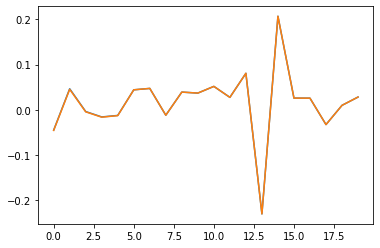

In [351]:
# Active power
# From complex power
vmag = result['bus'][:,VM]
vang = result['bus'][:,VA]*np.pi/180  # In radian
vcomplex = vmag*np.exp(1j*vang)
Sf = np.diag(Cf@vcomplex)@np.conjugate(Yf)@np.conjugate(vcomplex)

# From active power
Pf = -(np.diag(Cf@vmag)@np.diag(Ct@vmag)@(np.diag(gs)@np.cos(A@vang) + np.diag(bs-bc/2)@np.sin(A@vang)) - gs*(Cf@vmag**2))
Qf = -(np.diag(Cf@vmag)@np.diag(Ct@vmag)@(np.diag(gs)@np.sin(A@vang) - np.diag(bs-bc/2)@np.cos(A@vang)) + bs*(Cf@vmag**2))
plt.plot(Qf)
plt.plot(np.imag(Sf))

In [352]:
np.imag(Sf) - Qf

array([-6.37582737e-04, -1.26220922e-03, -6.55299381e-04, -4.89311899e-04,
       -3.84250664e-04, -7.79263340e-06, -7.10542736e-15, -8.88178420e-16,
       -2.22044605e-16,  0.00000000e+00,  0.00000000e+00, -5.23886490e-16,
        0.00000000e+00, -8.88178420e-16, -2.80331314e-15,  0.00000000e+00,
        4.44089210e-16,  0.00000000e+00,  0.00000000e+00,  4.44089210e-16])

In [298]:
Pf - pf_result

array([ 0.00000000e+00,  5.55111512e-17,  2.77555756e-16, -3.33066907e-16,
        1.11022302e-16,  8.88178420e-16, -2.77555756e-17,  4.30211422e-16,
       -8.67361738e-19,  6.76542156e-17,  3.33066907e-16,  0.00000000e+00,
       -2.22044605e-16,  4.44089210e-16,  5.55111512e-17, -4.44089210e-16,
        1.11022302e-16, -3.33066907e-16, -6.66133815e-16,  5.55111512e-17])

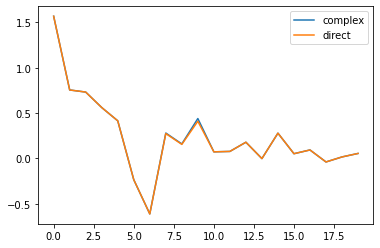

In [258]:
import matplotlib.pyplot as plt
plt.plot(np.real(Sf), label = 'complex')
plt.plot(Pf, label = 'direct')
plt.legend()

In [259]:
Pf - np.real(Sf)

array([-8.88178420e-16,  0.00000000e+00, -7.21644966e-15, -9.54791801e-15,
        1.11022302e-15,  8.88178420e-16,  3.01980663e-14, -6.17353793e-03,
       -4.97473850e-03, -2.99547367e-02,  3.06421555e-14,  1.12354570e-13,
       -2.44249065e-14,  2.84876289e-14,  4.44089210e-15, -3.90798505e-14,
        5.10702591e-15,  4.08562073e-14,  8.88178420e-16,  7.99360578e-15])

In [262]:
bs

array([-15.26308652,  -4.23498368,  -4.78186315,  -5.11583833,
        -5.1939274 ,  -5.06881698, -21.57855398,  -4.78194338,
        -1.79797907,  -3.96793905,  -4.09407434,  -3.17596397,
        -6.10275545,  -5.67697985,  -9.09008272, -10.36539413,
        -3.02905046,  -4.40294375,  -2.25197463,  -2.31496348])

In [266]:
np.imag(Yf)

array([[ 984.73691348,   15.26308652,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ 995.76501632,    0.        ,    0.        ,    0.        ,
           4.23498368,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  995.21813685,    4.78186315,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  994.88416167,    0.        ,    5.11583833,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  994.